# Probabilistic Programming - 1

### Preliminaries

- Goal 
  - Learn to write basic probabilistic programs  
- Materials        
  - Mandatory
    - These lecture notes.
    - Intro to programming in Julia (https://youtu.be/8h8rQyEpiZA?t=233).
  - Optional
    - Cheatsheets: how does Julia differ from Matlab / Python (https://docs.julialang.org/en/v1/manual/noteworthy-differences/index.html).
    - Getting started with ForneyLab (https://biaslab.github.io/forneylab/docs/getting-started/).
    - Tutorials using Turing.jl (https://turing.ml/dev/tutorials/0-introduction/)

So far you've been doing all your calculations by hand. As you have probably learned, this is timeconsuming and error prone. In this lesson we are going to introduce Probabilistic Programming as a method to automate this labour away. We will cover 2 packages - ForneyLab and Turing - and show you how to specify probabilistic models in both. Afterwards, you'll get your first taste of Probabilistic Programming by solving your first problem! The main takehome point is that while Probabilistic Programming requires some specialised mindware in terms of probability theory and correct model specification, implementation is easy once you have the right tools.

# Introduction to ForneyLab

ForneyLab (link) is a Probabilistic Programming toolbox developed inhouse at BIASLab. ForneyLab utilises the FFG formalism that you are familiar with by now to describe models. Inference is performed through variational procedures or, if applicable, exact inference. This is the core feature of ForneyLab: A large library of analytical update rules similar to what you have derived so far. This provides fast, deterministic inference with convergence guarantees, provided you give it the right generative model.
Things to keep in mind when using ForneyLab:
1. It is optimised for Dynamical Systems and time series data. It'll be extra fast in these circumstances
2. Relies on deterministic update rules - you will get the same result each time
3. If you find a bug, please tell us :) 

Now, let's work through an example using ForneyLab

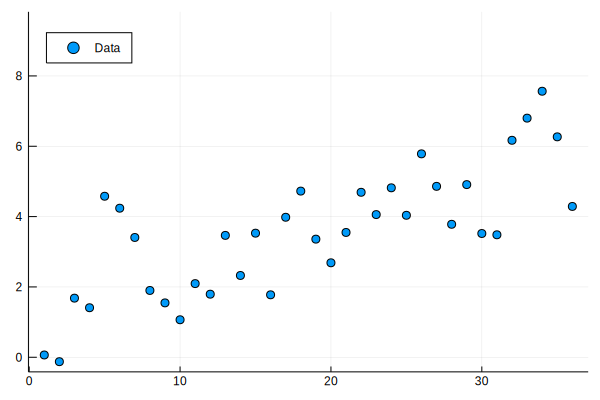

In [1]:
# Let's start by generating some data
using Plots
true_W = [1.0,0.5]
true_σ = 1.
sqrt_n = 6.
n=Int32(sqrt_n^2)


function generate_data(true_W,true_σ,sqrt_n)
    x_data = [[Float64(x1),Float64(x2)] for x1 in 0:sqrt_n for x2 in 0:sqrt_n]
    y_data = [true_W' * x + randn() * true_σ for x in x_data]
    return x_data,y_data
end
    
x_data,y_data = generate_data(true_W,true_σ,sqrt_n)
scatter(1:n,y_data,label="Data",legend=:topleft)

To model our data, we define a model using ForneyLab. We will try a linear regression of the form
INSERT LATEX EQUATION
The first thing we need to do is to import ForneyLab and instantiate a Factor Graph.

In [2]:
using ForneyLab
g = FactorGraph();

Now that we have a FactorGraph, we can start adding variables to it. This is the point where we specify our probabilistic model. When doing Probabilistic Programming, the core challenge is good model specification. To keep it simple, let's start by defining a model for a single x/y pair.


In [3]:

# Let's create a random variable for our input data x. In ForneyLab we use the @RV macro to denote Random Variables
@RV x 

# Now let's define a prior over the weights W. We use a 2 dimensional Gaussian since we have 2 weights
@RV W ~ GaussianMeanVariance([0,0],[1 0 ; 0 1])

# And finally our linear model for y
@RV y ~ GaussianMeanVariance(dot(W,x), 1)


# Visualise the graph
ForneyLab.draw()

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.38.0 (20140413.2041)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 10655170472235458093 -->
 10655170472235458093 
 
 clamp_2 
 
<!-- 7652756280295345872 -->
 7652756280295345872 
 
 clamp_1 
 
<!-- 8790261946880900685 -->
 8790261946880900685 
 
 𝒩 
 gaussianmeanvariance_2 
 
<!-- 17242232252650199984 -->
 17242232252650199984 
 
 dot 
 dotproduct_1 
 
<!-- 8790261946880900685--17242232252650199984 -->
 8790261946880900685--17242232252650199984 
 
 variable_1 
 1 out 
 2 m 
 
<!-- 953679935071266495 -->
 953679935071266495 
 
 clamp_3 
 
<!-- 8790261946880900685--953679935071266495 -->
 8790261946880900685--953679935071266495 
 
 clamp_3 
 1 out 
 3 v 
 
<!-- 10076739521485642576 -->
 10076739521485642576 
 
 𝒩 
 gaussianmeanvariance_1 
 
<!-- 17242232252650199984--10076739521485642576 -->
 17242232252650199984--10076739521485642576 
 
 W 
 1 out 
 3 in2 
 
<!-- 10076739521485642576--10655170472235458093 -->
 10076739521485642576--10655170472235458093 
 
 clamp_2 
 1 out 
 3 v 
 
<!-- 10076739521485642576--7652756280295345872 -->
 10076739521485642576--7652756280295345872 
 
 clamp_1 
 1 out 
 2 m 
 
<!-- 153017463520857378462 -->
 153017463520857378462 
 
<!-- 153017463520857378462--8790261946880900685 -->
 153017463520857378462--8790261946880900685 
 
 y 
 1 out 
 
<!-- 81731160858687009572 -->
 81731160858687009572 
 
<!-- 81731160858687009572--17242232252650199984 -->
 81731160858687009572--17242232252650199984 
 
 x 
 2 in1

If you take a look at the graph, you will see that it has some open edges for x and y. This is where we want to feed in our data. To do so in ForneyLab, we designate them as placeholders. This means that we do not give them a value immediately but want them to take one on at a later time - such as when we want to feed in the data.

In [4]:
placeholder(x,:x,dims=(2,)) # The dims flag tells ForneyLab to expect 2 dimensional inputs here
placeholder(y,:y);

Now that we have our model, it is time to get our inference algorithm. ForneyLab includes the Belief Propagation algorithm for exact inference which we will utilise here. The details of the procedure are not important at this time, so feel free to treat it as a "magic inference button".
ForneyLab works by directly generating new Julia code containing the inference algorithm. When we parse this code, we get a function (step!) which we can then run to execute the inference procedure.

If you are feeling adventurous, feel free to experiment with some of the other inference tools available in ForneyLab. Do you get different results?

In [5]:
algo = sumProductAlgorithm(W) # Generate Julia code for inference. The argument tells ForneyLab which variable we want the posterior for
eval(Meta.parse(algo)) # Evaluate the generated code to get the step! function

step! (generic function with 3 methods)

Next we need to create a dictionary with our data. Since our model is only for a single data point, we create a dictionary holding just one random x/y pair

In [6]:
data = Dict(:x => x_data[10],
            :y => y_data[10]);

Now, we feed our data dictionary into the step! function, do inference and observe the results! For clarity we have written the model specification below as well so you can get a sense of what a full ForneyLab program looks like.

In [7]:
g = FactorGraph(); # Instantiate Factor Graph

# Specify probabilistic model
@RV x 
@RV W ~ GaussianMeanVariance([0,0],[1 0 ; 0 1])
@RV y ~ GaussianMeanVariance(dot(W,x), 1)

# Denote placeholders
placeholder(x,:x,dims=(2,)) 
placeholder(y,:y);

# Generate inference algorithm
algo = sumProductAlgorithm(W) 
eval(Meta.parse(algo)) 

# Set up data dictionary
data = Dict(:x => x_data[10],
            :y => y_data[10]);

# Do inference
marginals = step!(data)

# Print results
println("Posterior mean: ",mean(marginals[:W]))
println("Posterior Variance: ",var(marginals[:W]))

Posterior mean: [0.17772360054307657, 0.3554472010861533]
Posterior Variance: [0.8333333333325278, 0.3333333333331111]


That wasn't particurlarly accurate because we only used a single data point. Let's create a new model that takes in the full data set instead and see if we get better results.

In [8]:
g2 = FactorGraph() # Instantiate new Factor Graph

# Create vectors to hold variables for all data points
x = Vector{Variable}(undef,n) 
y = Vector{Variable}(undef,n)

# Define a prior over the weights. These are shared for all data points
@RV W ~ GaussianMeanVariance([0,0],[1 0 ; 0 1])

# Loop over the dataset
for i in 1:n
    @RV x[i] # We can use indexing to fill a vector with random variables
    @RV y[i] ~ GaussianMeanVariance(dot(W,x[i]), 1) 
    placeholder(x[i],:x,index=i,dims=(2,)) # To define placeholders in vectors, we use the index flag
    placeholder(y[i],:y,index=i)
end

# Generate a new inference algorithm
algo = sumProductAlgorithm(W)
eval(Meta.parse(algo)) 

# Now we can fit the entire data set in our model!
data = Dict(:x => x_data,
            :y => y_data)

# Perform inference and observe the results
marginals = step!(data)
println("Posterior mean: ",mean(marginals[:W]))
println("Posterior Variance: ",var(marginals[:W]))

Posterior mean: [1.02273154118299, 0.4400740351645771]
Posterior Variance: [0.007179293406383546, 0.0037155992190935068]


Much better! The trick to note above is the use of vectors and indices to handle multiple data points. 

# Introduction to Turing
Now let's build the same model in Turing. Turing is another Probabilistic Programming library available in Julia. Unlike ForneyLab, Turing relies on sampling based schemes to perform inference. This has advantages and disadvantages which you will investigate in the coming lessons.
Things to keep in mind when using Turing:
1. Sampling based inference always runs. This means Turing can handle a wider class of problems than ForneyLab
2. Sampling based inference is stochastic. Your results will vary between runs.
3. Sampling based inference is slow. 

Let's build a model! Since we have already covered the model specification, we can go a little faster this time

In [10]:
using Turing # Import the library

# Turing uses the @model macro to define the model function
@model linear_regression(x, y, n) = begin # Number of datapoints as additional input
    W ~ MvNormal([0.,0.],[1. 0. ; 0. 1.]) # As before we define a 2 dimensional Gaussian prior for the weights

    for i in 1:n # Loop over data points
        y[i] ~ Normal(W' * x[i], 1) # Estimate y as the dot product of W and x
    end
end
;

And that's it! Now we are ready to do inference. For Turing that means selecting a sampling algorithm and setting the associated parameters. For this example we will use the No U-Turn Sampler (NUTS). As above, don't worry too much about the details of the inference algorithm. Though if you are feeling adventurous, feel free to try out the other sampling algorithms available or try out different parameter settings. Can you get better results? What happens to the runtime?

In [35]:
# Disable status bars for the inference procedure
Turing.turnprogress(:false)

# Run the sampling procedure and generate an MCMCChain
chain = Turing.sample(linear_regression(x_data,y_data,n), NUTS(500,0.65),2000);

┌ Info: [Turing]: global PROGRESS is set as false
└ @ Turing /home/mkoudahl/.julia/packages/Turing/xFzfF/src/Turing.jl:23
┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /home/mkoudahl/.julia/packages/Turing/xFzfF/src/inference/hmc.jl:548


The inference procedure has introduced a new object: The MCMCChain. This object holds the results of our sampling procedure as well as some diagnostic information to assess convergence of the sampler. Let's take a look at what's inside using the describe() function in Turing

In [ ]:
describe(chain)

The above table holds a lot of information. A lot of the entries are specific to the inference algorithm so we will focus on the results that matter - that being the posterior distribution over the weights W[1] and W[2]. Did the sampler succesfully manaage to recover the parameters of the data generating process? 

# ADD MORE STUFF ON HOW TO WORK WITH MCMC CHAINS

Now it's your turn! Below are 2 tasks to get you started working with Probabilistic Programming. You should attempt both of them with both ForneyLab and Turing. An important part of being a good probabilistic programmer is to use the right tool for the right job and to do that you need to be familiar with multiple toolboxes. Good luck and may the odds be ever in your favour

#### Assigment 1. 
Your task is to extend the regression models above to include an intercept term. You can do this either by extending the input vector with a column of 1's and add an additional weight to W or by augmenting your model with an entirely new variable. Either approach has advantages and disadvantages depending on the library you use.

In [ ]:
# Your code here

#### Assignment 2.
The code below generates a dataset of 0's and 1's. Your task is to turn the regression models above into binary classifiers. To do that you will need to change the likelihood and use a logistic function on the output of the regression. To that end ForneyLab supplies the Probit() node and Turing the sigmoid() function

In [ ]:
# Your code here

- Small introductory story
- Binary logistic regression
- Linear regression

#### Introduction to Turing

- Small introductory story
- Binary logistic regression
- Linear regression

## Assignment: multivariate extension of logistic regression

Synthetic data set

## Assignment: Real-world problem

List of data sets: Iris, Titanic, Old faithful, UCI-ML repo

## (Optional / -> block 4?) Model comparison